# Benchmark dataset creator

Léa Bouffaut, Ph.D. -- K. Lisa Yang Center for Conservation Bioacoustics, Cornell University

lea.bouffaut@cornell.edu

### Motivations and objectives
Many bioacoustic project are sitting on a goldmine of already annotated datasets. We want to create a standardized pipeline for creating, storing, sharing and
using data that is flexible and repeatable  to train and test AI models for different applications. More details in https://www.overleaf.com/read/yfcgvngmwfbs#e349e7

This notebook aims to create a benchmark dataset and standardizes:
* File duration
* Sampling frequency
* Mono channel
* Bit depth
* File name format
* Selection table fields

It also gives the option to change labels, e.g. to match with our standardized label format.


<b>It does NOT:</b>
* Filter the audio input beyond what is needed for resampling
* Normalize the audio file amplitude


For example, this schematic view presents (top) a raven project where a selection table is associated to several audio files of different lengths (bottom) the standardized benchmark clips and associated annotations. Note that annotations that are at the joinction between two export files are ignores, as well as those in remaining audio, too short in comparison with the selected export audio file duration.
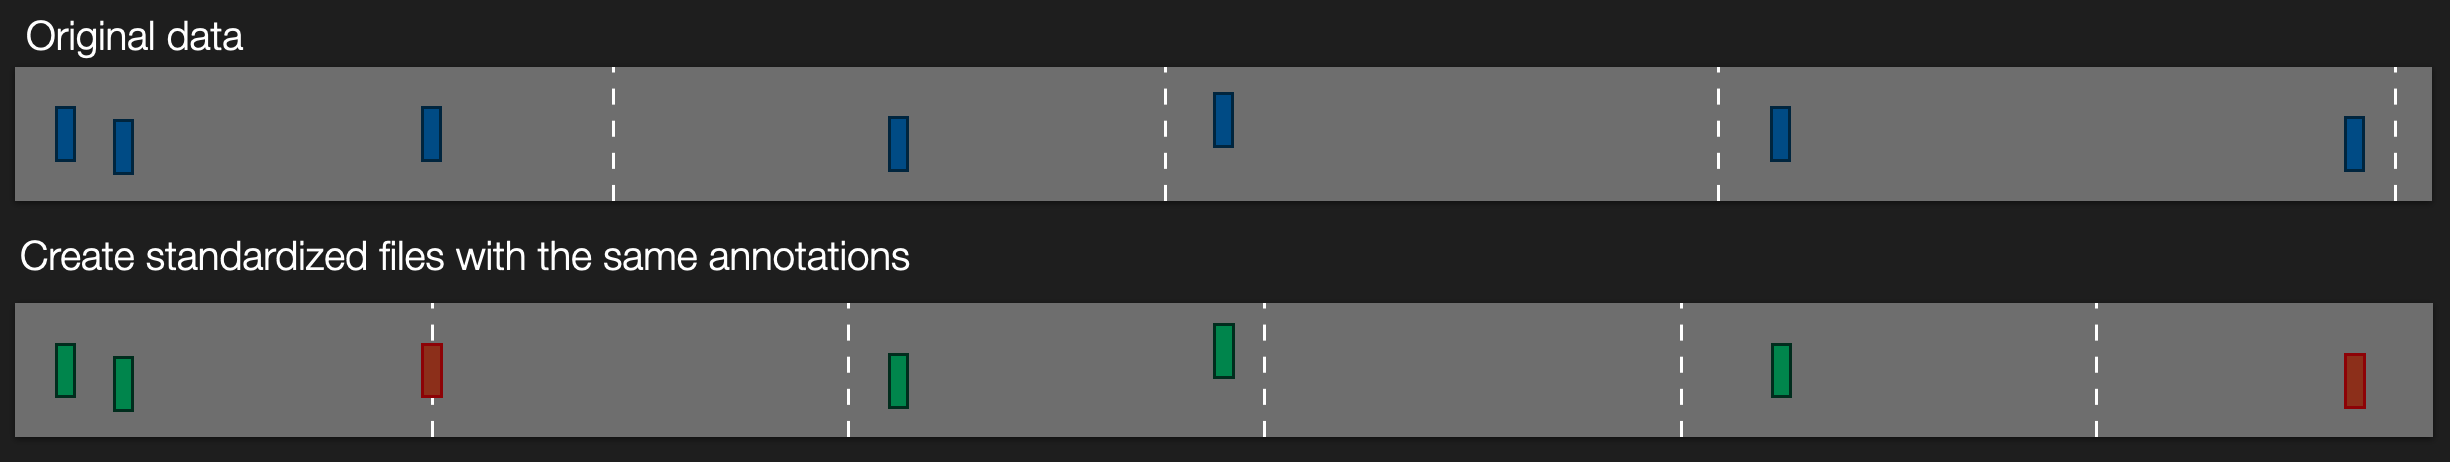

### Necessary information in selection tables
This project uses Raven Pro 1.6 selection tables. 
Selection tables by default contain the necessary information to draw a time-frequency box around a call and, an annotation column
* 'Begin Time (s)'
* 'End Time (s)'
* 'Low Frequency (Hz)'
* 'High Frequency (Hz)'
* 'Label'/'Tags'/Other

Selection tables can either be associated with (1) a single audio file or (2) multiple audio files. In the latter, it is essential that the following additional fields are present
* 'Begin Path'
* 'File Offset (s)'

We will consider and test that all selection tables should contain all of the aforementionned fields, with user defined field for the label column.

### Labels 
The following format is our suggested label format: 

`<LatinNameAccronym>.<Location>.<CallName>`

Where 
* `<LatinNameAccronym>` is a 6-letter combination of the first letters of each word,
* `<Location>` a 4-letter combination describing the geographical location of the recorder.
    - If underwater, give cardinal direction and abbreviation of the ocean/sea,
    - If on land, the first two letters are to specify the region and the last two letters are the ISO 3166 country codes \url{https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2#ZZ},

* `<CallName>` free-format vocalization descriptor.


### Outputs
Please refer to the [User-defined parameters](#User-defined-parameters) section to see the details on the output folder architecture. 

<div class="alert alert-block alert-info">
<b>This notebook will assit you in creating:</b> 
<ul>
  <li>Benchmark soundfiles based on user-input specifications</li>
  <li>a corresponding Raven selection table for each sound file, </li>
  <li>a two-colum file-matching csv (as used for Koogu) and,</li>
  <li>a recap annotation CSV file that will match previous datasets e.g, https://zenodo.org/records/7525805</li>
</ul>
</div>

------------------
Note specific to the Maryland audio data:
I need to first connect to mount W (/Volumes/ag-clo-repnas5.ad.cornell.edu) so U becomes (/Volumes/ag-clo-repnas5.ad.cornell.edu-1), otherwise I need to change the path in Begin Path / the list file!
------------------

### TODO
* OK - Automatically generate a 2-column csv as needed for Koogu, to associate on each line entry the full path of the created audio file and associated selection table. This can be done in the main loop 
* OK - Provide settings guidelines, 
* OK - needs to refine flac bit rate - message CrhisP and BenT. Provide an estimate of the benchmark dataset size based on the user+defined settings. E.g., if the goal is to host them on Zenodo I believe they should be  <50GB
* OK Implement label change
* FIX BUG in benchmark_size_estimator
* Generate metada file. --> Look into automatic formats, we can then report methods and user inputs
* This <i>could</i> be paralellized, e.g., working on several audio files at once 
* Routine to extract 3s clips for BirdNET embeddings models, with, again user-tunable settings e.g., clip overlap

In [1]:
import benchmark_dataset_creator as bc
import pandas as pd

## User-defined parameters <a id='User-defined-parameters'></a>

The following field is a series of user-defined parameters to create the Benchmark dataset:
* `Original project name`, helps you keep track of the origin of the data, should be written between as a string of characters, which in Python is between quotes 'MyProjectName'. This code wil create the folder architecture, please do not end this entry by "/" or "\"
* `Audio duration (s)`, is the chosen export audio file duration for the Benchmark dataset. Our recommendation is to set it to encompass the vocalization(s) of interest but also some context. Think, what is the minimum duration would represent the signal's repetition or call/cue rate (with several annotations)?
* `fs (Hz)` is the ampling frequency, to be set at minima at double the maximum frequency of the signals of interest. If relevant, BirdNET uses fs = 48 kHz (see: https://github.com/kahst/BirdNET-Analyzer?tab=readme-ov-file#technical-details)
* `Bit depth` determines the number of possible amplitude values we can record for each audio sample, for SWIFT units it is set to 16 bits and to 24 bits for Rockhopper.
* `Export label` defines the name of the label column for the created Raven selection tables
* `Export folder` is where the data will be saved following this structure:

```
Export_folder/
│   README.md
│   file001.txt    
│
└───Original_project_name/
    │   Original_project_name_annotations.csv
    │   Original_project_name_audio_seltab_map.csv
    │
    └───audio/
    │   │   Original_project_name_audiofile001.flac
    │   │   Original_project_name_audiofile002.flac
    │   │   ...
    │   
    └───annotations/
        │   Original_project_name_audiofile001.txt
        │   Original_project_name_audiofile002.txt
        │   ...
```

The variable `filename_selection_table` should be:
* a path to a <b>selection table</b> if dealing with a single audio file in total or a project with multiple audio files.
* a path to a <b>folder</b> if dealing with one selection table associated with a single audio file.

<div class="alert alert-block alert-info">
<b>Tip:</b> A few fields below, we provide a <b>Benchmark dataset size estimator</b> that can also be used to inform the choice of the user inputs. For example, if you wish to publish your repository on Zenodo, they currenlty accept datasets up to 50GB.
</div>

In [2]:
export_settings = {
    'Original project name': '2021_CLOCCB_BermudaPlantBank_S1105', 
    'Audio duration (s)': 300,  
    'fs (Hz)': 8000, 
    'Bit depth': 24,
    'Export label': 'Tags',
    'Export folder': 'benchmark_data'
    }

filename_selection_table = '/Volumes/DCLDE/projects/2022_CLOCCB_IthacaNY_S1112/Atlantic_whales/2021_CLOCCB_BermudaPlantBank_S1105/annotations/'

# Create the directories
bc.create_path(export_settings)


2021_CLOCCB_BermudaPlantBank_S1105/
    annotations/
    audio/
None
Delete data? [Y/n] 

 Y


## Load a selection table

In [14]:
selection_table_df = bc.load_selection_table(filename_selection_table)
                     
if selection_table_df.empty == False:
    display( selection_table_df)

All required fields are in the selection tables


,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),File Offset (s),Begin Path,Begin File,Species,Call Type
0,1,Spectrogram 2,1,939.346644,953.140604,35.307,89.960,939.3466,/Volumes/DCLDE/projects/2022_CLOCCB_IthacaNY_S...,S1105BMU01_250K_S01_RH410_20220113_174851Z.flac,sei,triplet
1,2,Spectrogram 2,1,1031.924582,1034.977343,43.529,85.607,1031.9246,/Volumes/DCLDE/projects/2022_CLOCCB_IthacaNY_S...,S1105BMU01_250K_S01_RH410_20220113_174851Z.flac,sei,singlet
0,1,Spectrogram 2,1,1973.962291,1980.520075,28.536,92.379,1973.9623,/Volumes/DCLDE/projects/2022_CLOCCB_IthacaNY_S...,S1105BMU01_250K_S01_RH410_20220203_095913Z.flac,sei,doublet
1,2,Spectrogram 2,1,2088.158191,2094.263715,29.987,82.705,2088.1582,/Volumes/DCLDE/projects/2022_CLOCCB_IthacaNY_S...,S1105BMU01_250K_S01_RH410_20220203_095913Z.flac,sei,doublet
2,3,Spectrogram 2,1,2224.266250,2230.710969,26.601,86.575,2224.2662,/Volumes/DCLDE/projects/2022_CLOCCB_IthacaNY_S...,S1105BMU01_250K_S01_RH410_20220203_095913Z.flac,sei,doublet
...,...,...,...,...,...,...,...,...,...,...,...,...
0,1,Spectrogram 2,1,124.371773,126.633078,32.889,71.581,124.3718,/Volumes/DCLDE/projects/2022_CLOCCB_IthacaNY_S...,S1105BMU01_250K_S01_RH410_20211230_194152Z.flac,sei,singlet
1,2,Spectrogram 2,1,289.198404,295.303928,26.601,70.130,289.1984,/Volumes/DCLDE/projects/2022_CLOCCB_IthacaNY_S...,S1105BMU01_250K_S01_RH410_20211230_194152Z.flac,sei,doublet
2,3,Spectrogram 2,1,555.195932,561.414520,28.536,66.261,555.1959,/Volumes/DCLDE/projects/2022_CLOCCB_IthacaNY_S...,S1105BMU01_250K_S01_RH410_20211230_194152Z.flac,sei,doublet
3,4,Spectrogram 2,1,654.105523,656.592959,26.601,70.614,654.1055,/Volumes/DCLDE/projects/2022_CLOCCB_IthacaNY_S...,S1105BMU01_250K_S01_RH410_20211230_194152Z.flac,sei,singlet


In [5]:
# User-defined label key, should be in the Selection table keys displaid above
label_key = 'Call Type'

## Test the selection table and estimate the size of the benchmark dataset

In [6]:
# Remove duplicates (e.g., if we have both the spectrogram and waveform view)
selection_table_df.drop_duplicates(subset='Begin Time (s)', keep="last");

# Estimate the size of the dataset
bc.benchmark_size_estimator(selection_table_df, export_settings, label_key)

All files can be divided into 11 x 300-s clips
File size are estimated with a flac compression factor of 50% which may vary depending on the file.
Estimated file size ... 4 MB
 > Estimated Benchmark dataset size ... 223 MB


## Check the labels

In [7]:
unique_labels = selection_table_df[label_key].unique()

print('Unique label list:')
for lab in unique_labels:
    print(lab)

Unique label list:
triplet
singlet
doublet
B
C
D


If you wish to replace labels run the cell below where `new_labels_dict` is a Python dictionnary connecting:
> the orignal label on the left || the new label on the right

both are strings, i.e., text between single quotes for example:
```
new_labels_dict = {
    'NARW': 'EUBGLA.NWAO.Upcall',
    'BW': 'BALMUS.NWAO.Dcall'
}
```
Note: if the left side does not contain any of your original label list, no changes will be made.

In [8]:
# New label dictionnary
new_labels_dict = {
    'NARW': 'EUBGLA.NWAO.Upcall',
    'na': 'BALMUS.NWAO.Dcall',
}

# Swap the labels
selection_table_df = bc.update_labels(selection_table_df, new_labels_dict, label_key)

Skipping: Original label NARW not found in the selection table
Skipping: Original label na not found in the selection table
New unique label list:
triplet
singlet
doublet
B
C
D


## Create the Benchmark dataset

We use selection to refer to the time boundaries of a row in a selection table and clip/export clip when referring to the longer chunck of data that will become the benchmark audio data.

### Technical notes
* The data is loaded and resample with Librosa where the very high quality sox method is implemented. This method does not require to apply a low-pass filter to the data
* Bit depth soundfile only supports: `sf.available_subtypes('FLAC')` helpful GIT: https://github.com/mgeier/python-audio/blob/master/audio-files/audio-files-with-pysoundfile.ipynb
    * 'PCM_S8': 'Signed 8 bit PCM',
    * 'PCM_16': 'Signed 16 bit PCM',
    * 'PCM_24': 'Signed 24 bit PCM'
    So we need to use another method to create 32 bit files -> Max is 24, we're fine.
* At the moment only flac files are supported for the export. Is there a need for wav files? Koogu ok with flac, what about BirdNET?
    


In [9]:
import time
start_time = time.time()

bc.benchmark_creator(selection_table_df, export_settings, label_key)

print(f'The Benchmark Dataset Creator took {time.time() - start_time} s to run')

  0%|          | 0/13 [00:00<?, ?it/s]

Ignored annotation...  Selection # 24, File S1105BMU01_250K_S01_RH410_20220114_214926Z.flac, Channel 1, 1799.0729-1803.482444677 s
Ignored annotation...  Selection # 32, File S1105BMU01_250K_S01_RH410_20220114_214926Z.flac, Channel 1, 2092.1155-2100.2561978649996 s
Ignored annotation...  Selection # 23, File S1105BMU01_250K_S01_RH410_20211227_064006Z.flac, Channel 1, 1498.3643-1502.0954531880002 s
Ignored annotation...  Selection # 9, File S1105BMU01_250K_S01_RH410_20211224_083838Z.flac, Channel 1, 1794.4823-1800.700888646 s
The Benchmark Dataset Creator took 17.213078022003174 s to run
